This is a similar example as in the previous notebook, but here there is not just a
rotation between the two coordinate frames, but a mirroring as well (which cannot
be described by only a rotation)

In [1]:
%matplotlib inline

In [2]:
from grale.all_nb import *

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [3]:
# The cosmological model
cosm = cosmology.Cosmology(0.7, 0.3, 0, 0.7)
cosmology.setDefaultCosmology(cosm)

In [4]:
# Now we'll start with a lens that is less symmetric, two NSIE models next to
# each other, but of different sizes. This way a difference can be seen when
# the situation is mirrored
z_lens = 0.4
z_s = 2.0

Dd = cosm.getAngularDiameterDistance(z_lens)
Dds = cosm.getAngularDiameterDistance(z_lens, z_s)
Ds = cosm.getAngularDiameterDistance(z_s)

l = lenses.CompositeLens(Dd, [
      { "factor": 1, "angle":0, "x": -3*ANGLE_ARCSEC, "y":0,
        "lens": lenses.NSIELens(Dd, { "velocityDispersion": 300000, "coreRadius": 1*ANGLE_ARCSEC, "ellipticity": 0.5})},
      { "factor": 1, "angle":0, "x": 2*ANGLE_ARCSEC, "y":0,
        "lens": lenses.NSIELens(Dd, { "velocityDispersion": 200000, "coreRadius": 0.5*ANGLE_ARCSEC, "ellipticity": 0.5})},
])

li = plotutil.LensInfo(l, size=16*ANGLE_ARCSEC, zd=z_lens, zs=z_s)

In [5]:
# Here we'll construct a mirrored version of the lens, which is also rotated further
rotAngleDeg = 30
rotAngle = rotAngleDeg/180*np.pi
x0 = 3*ANGLE_ARCSEC
y0 = 1*ANGLE_ARCSEC

# Mirrored and rotated version
l2 = lenses.CompositeLens(Dd, [{
        "factor": 1, "x": x0, "y": y0, "angle": rotAngleDeg, 
        "lens": lenses.CompositeLens(Dd, [
                    { "factor": 1, "angle":0, "x": 3*ANGLE_ARCSEC, "y":0,
                      "lens": lenses.NSIELens(Dd, { "velocityDispersion": 300000, "coreRadius": 1*ANGLE_ARCSEC, "ellipticity": 0.5})},
                    { "factor": 1, "angle":0, "x": -2*ANGLE_ARCSEC, "y":0,
                       "lens": lenses.NSIELens(Dd, { "velocityDispersion": 200000, "coreRadius": 0.5*ANGLE_ARCSEC, "ellipticity": 0.5})},
    ])
}])

li2 = plotutil.LensInfo(l2, size=16*ANGLE_ARCSEC, zd=z_lens, zs=z_s)

In [6]:
# Our grid of positions for the first lens is again aligned with the coordinate axes
# The grid is somewhat smaller in one direction, to make the effect of the transformation
# more clear
thetas = util.createThetaGrid(-V(7,7)*ANGLE_ARCSEC, V(3,7)*ANGLE_ARCSEC, 15, 20)

In [7]:
# To get the same relative positions for the second lens, we'll appy a mirroring of the
# x-axis, a rotation and an offset
thetas2 = thetas.copy()
thetas2[:,:,0] = -thetas2[:,:,0]

rotMatrix = np.array([
    [ np.cos(rotAngle), -np.sin(rotAngle)],
    [ np.sin(rotAngle), np.cos(rotAngle)]
])

thetas2 = np.matmul(rotMatrix, thetas2.reshape((-1,2)).T).T.reshape(thetas.shape)
thetas2[:,:,0] += x0
thetas2[:,:,1] += y0

Text(value='')

FloatProgress(value=0.0)

Text(value='')

FloatProgress(value=0.0)

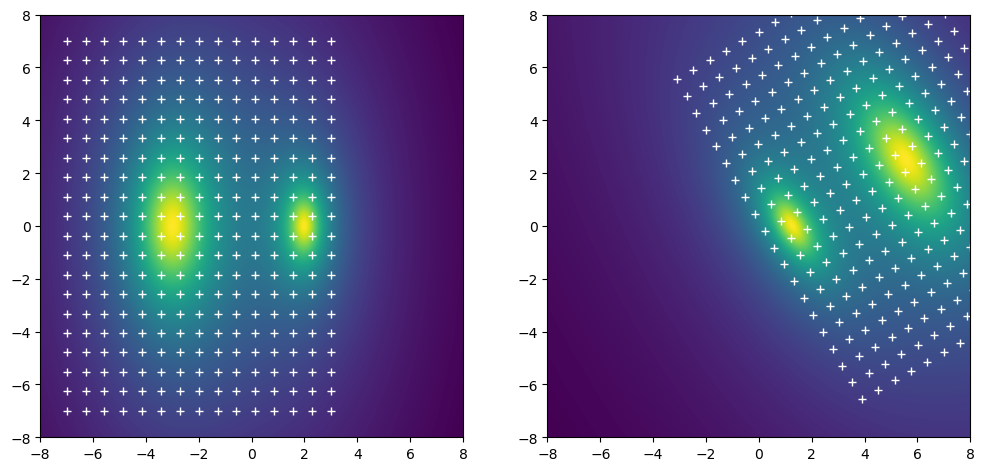

In [8]:
# A plot of the situations shows that these positions correspond to the same positions
# in each frame of reference
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plotutil.plotDensity(li)
plt.plot(thetas[:,:,0]/ANGLE_ARCSEC, thetas[:,:,1]/ANGLE_ARCSEC, '+', color="white")
plt.subplot(1,2,2)
plotutil.plotDensity(li2)
plt.plot(thetas2[:,:,0]/ANGLE_ARCSEC, thetas2[:,:,1]/ANGLE_ARCSEC, '+', color="white");

In [9]:
# Let's get the kappa and gamma values for the two situations again
aDerivs = l.getAlphaVectorDerivatives(thetas)
axx, ayy, axy = aDerivs[:,:,0], aDerivs[:,:,1], aDerivs[:,:,2]
axx *= Dds/Ds
ayy *= Dds/Ds
axy *= Dds/Ds
kappa = 0.5*(axx+ayy)
gamma1 = 0.5*(axx-ayy)
gamma2 = axy

aDerivs2 = l2.getAlphaVectorDerivatives(thetas2)
axx2, ayy2, axy2 = aDerivs2[:,:,0], aDerivs2[:,:,1], aDerivs2[:,:,2]
axx2 *= Dds/Ds
ayy2 *= Dds/Ds
axy2 *= Dds/Ds
kappa_2 = 0.5*(axx2+ayy2)
gamma1_2 = 0.5*(axx2-ayy2)
gamma2_2 = axy2

In [10]:
# As expected, the kappa values are basically the same 
np.min(kappa - kappa_2), np.max(kappa - kappa_2)

(-2.220446049250313e-16, 1.6653345369377348e-16)

In [11]:
# But not the gamma values, of course
np.min(gamma1 - gamma1_2), np.max(gamma1 - gamma1_2)

(-0.09807759413404087, 0.1562528395813783)

In [12]:
np.min(gamma2 - gamma2_2), np.max(gamma2 - gamma2_2)

(-0.27063785698185655, 0.16987537612427817)

In [13]:
# Now we indicate that there's a mirroring involved between the coordinate frames, and
# let the function figure out the rest.
adjustedGamma1, adjustedGamma2, angle = util.adjustShearMeasurements(thetas, gamma1, gamma2, thetas2, mirror=True, tol=1e-10)
print("Found rotation of", angle/np.pi*180, "degrees from first frame to second frame")

Found rotation of -29.999999995382836 degrees from first frame to second frame


In [14]:
# Now, the adjusted gamma values are nearly identical to the ones we'd expect
np.min(adjustedGamma1-gamma1_2), np.max(adjustedGamma1-gamma1_2)

(-1.3388255781787706e-11, 2.987966818412957e-11)

In [15]:
np.min(adjustedGamma2-gamma2_2),np.max(adjustedGamma2-gamma2_2)

(-2.5183029273012636e-11, 1.580709174664463e-11)